In [3]:
import numpy as np
import matplotlib.pylab as plt
import uproot
import awkward as ak
import seaborn
import RA_funcs as rf
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.special import gamma



imports work


In [4]:
hit_data_1093 = rf.get_ROOT_data_zip_RECO(1093)

# hit_data_1101_RECO = rf.get_ROOT_data_zip_RECO(1101)

# hit_data_1080 = rf.get_ROOT_data_zip_RECO(1080)

# hit_data_1101 = rf.get_ROOT_data_zip("TB_FIRE_1101_hits.root")

1093 RECONSTRUCTED finished


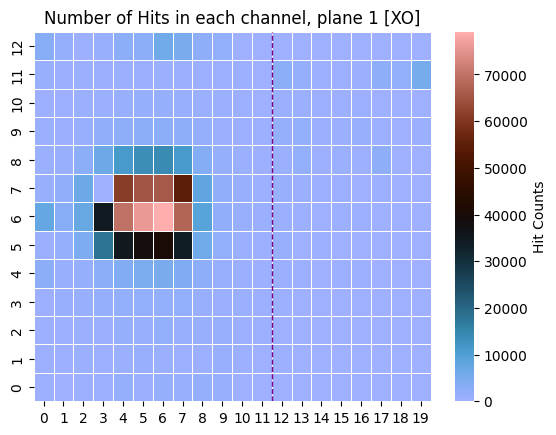

In [3]:
rf.hits_amount_colormap_single_plane(hit_data_1093, 1, cmap="berlin")

In [22]:
# returns histogram of the energie of events starting at the stated X position
def shower_energy_histo_single_location(hit_data, Position, specific_Y = "all_rows"):

    # get only showers starting at the first plane to identify the initial location
    plane_7 = hit_data[hit_data.plane == 7]
    mask = ak.num(plane_7) == 1
    first_plane_starting_events = hit_data[mask]

    # determine the initial location of the shower
    # get the data on the first plane
    plane_7_clean = plane_7[mask]
    plane_7_channel = plane_7_clean.ch

    # divide by x positions
    y, x = divmod(plane_7_channel, 20) #y is the quontinent and is the row, x is the remainder and column
    x_list = x.to_list()
    x_ak = ak.Array(x_list)
    x_avg = ak.mean(x_ak, axis = 1)
    
    # compute the shower energy for each event
    hit_amp_array = first_plane_starting_events.amp
    event_shower_amp_array = ak.sum(hit_amp_array, axis = 1)

    # Filter for specific row only
    if specific_Y  != "all_rows":
        y = ak.flatten(y)
        mask_Y = y == specific_Y
        x_avg = x_avg[mask_Y]
        event_shower_amp_array = event_shower_amp_array[mask_Y]
        title = f'Energy Histograms for events starting at different initial columns, y = {specific_Y}'
    
    
    
    # get the shower energy for the X position for all events
    amps_divided_by_class, avg_amps, classes = rf.ak_groupby(x_avg, event_shower_amp_array)
    
    amps_class_position = amps_divided_by_class[amps_divided_by_class.classes == Position]
    amps_position = amps_class_position.data
    amps_position_clean = ak.flatten(amps_position[ak.num(amps_position) > 0])
    
    

    # Histogram
    max_range = 12000
    range = (0, max_range)
    bin_size = 50
    bins = np.arange(0, max_range + 1, bin_size)
    
    # most common energy (peak of the histo)
    counts, bins = np.histogram(amps_position_clean, bins = bins, range=range)
    peak_idx = np.argmax(counts)
    peak_center = (bins[peak_idx] + bins[peak_idx + 1]) / 2
    

    # Histo Mean
    avg_amp = ak.mean(amps_position_clean)
    
    # Histo Standard deveiation (how spread is the data) marked as sigma
    std = ak.std(amps_position_clean)

    # standard deviation error of mean (how uncertain the mean is) marked as sigma_mean
    SEM = std/np.sqrt(len(amps_position_clean))
    


    # Multi-line string for the box
    textstr = '\n'.join((
        f'Mean = {avg_amp:.2f}',
        f'Peak = {peak_center:.2f}',
        rf'$\sigma$ = {std:.2f}',
        rf'$\sigma_{{\mu}}$ = {SEM:.2f}',
        # f'RMS = {RMS:.2f}',
        # f'STD = {STD:,}'
    ))

    # Place the box inside the axes
    plt.text(
        0.65, 0.75, textstr, transform=plt.gca().transAxes,
        fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
        )


    # plot the histogram with matplotlib
    plt.hist(amps_position_clean, bins = bins, range=range, label=f"avg = {avg_amp} \n peak = {peak_center}")
    plt.grid()
    plt.xlabel(f"Energy in Column {Position}")
    plt.ylabel("Counts")
    plt.title(f'Energy Histograms for events starting at different initial columns, y =  {specific_Y}')
    plt.show()


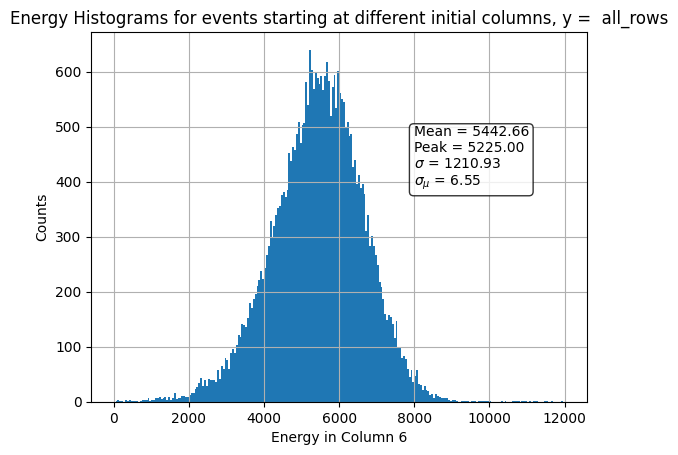

In [23]:
shower_energy_histo_single_location(hit_data_1093, 6)


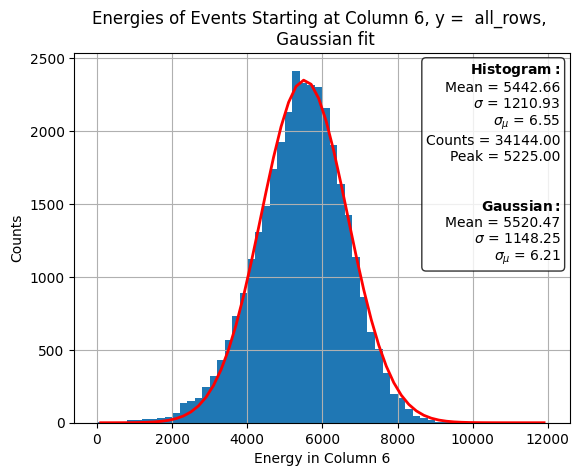

In [6]:
rf.Gaussian_fit_histo_single_column(hit_data_1093, 6, bin_size=200)

In [6]:
# returns the optimized fit values for Gamma
def fit_histo_to_Gamma(histo_data, bin_size):
    
    # convert data to numpy in order to fit
    histo_data = ak.to_numpy(histo_data)

    # statistics
    mean = np.mean(histo_data)
    sigma = np.std(histo_data)

    # bins paramaters
    max_range = 12000
    data_range = (0, max_range)
    bins = np.arange(0, max_range + 1, bin_size)

    # histogram data
    # counts, bin_edges = np.histogram(histo_data, bins=bins, range = data_range)
    counts, bin_edges = np.histogram(histo_data, bins=bins, range = data_range, density = True)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

    # Define Gaussian function
    def Gamma_pdf(x, A, alpha, theta):
        return A * 1/(gamma(alpha)*theta**alpha) * x**(alpha-1) * np.exp(-x/theta)
    
    # def Gamma_pdf(x, alpha, theta):
    #     return 1/(gamma(alpha)*theta**alpha) * x**(alpha-1) * np.exp(-x/theta)
    
    # Fit the Gaussian to histogram data 
    popt, pcov = curve_fit(Gamma_pdf, bin_centers, counts, p0=[1, (mean/sigma)**2, (sigma**2)/mean],bounds = ([0, 0, 0], [np.inf, np.inf, np.inf]))
    A_fit, alpha_fit, theta_fit = popt
    Gamma_Y = Gamma_pdf(bin_centers, *popt)
    return A_fit, alpha_fit, theta_fit, bin_centers, Gamma_Y


In [ ]:
# plot histogram with fit and statistics values
def Gamma_fit_histo_single_column(hit_data, Position, specific_Y = "all_rows", bin_size = 50):

    # data statistics
    mean_energy, std, sem, peak_energy, energies_in_column = rf.histo_statistics_single_column(hit_data, Position, specific_Y)
    counts = len(energies_in_column)

    # optimized gaussian values for the histo
    A_fit, alpha_fit, theta_fit, bin_centers, Gamma_Y = fit_histo_to_Gamma(energies_in_column, bin_size)
    
    # Fit statistics
    mu_fit = alpha_fit*theta_fit
    sigma_fit = np.sqrt(alpha_fit) * theta_fit

    # Multi-line string for the box
    textstr = '\n'.join((
        # histo
        rf'$\bf{{Histogram:}}$',
        f'Mean = {mean_energy:.2f}',
        rf'$\sigma$ = {std:.2f}',
        rf'$\sigma_{{\mu}}$ = {sem:.2f}',
        f'Counts = {counts:.2f}',
        f'Peak = {peak_energy:.2f}',
        '\n',
        # gaussian
        rf'$\bf{{Gamma_pdf:}}$',
        f'Mean = {mu_fit:.2f}',
        rf'$\sigma$ = {sigma_fit:.2f}',
        rf'$\sigma_{{\mu}}$ = {sigma_fit/np.sqrt(counts):.2f}',
        ))


    # place the text in the plot
    plt.text(
        0.98, 0.98, textstr,
        transform=plt.gca().transAxes,      # axes coordinates: (0,0) bottom-left, (1,1) top-right
        fontsize=10,
        verticalalignment='top',     # anchor the top of the box
        horizontalalignment='right', # anchor the right side of the box
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
    )




    # Histogram
    max_range = 12000
    range = (0, max_range)
    bins = np.arange(0, max_range + 1, bin_size)
    title = f'Energy Histograms for events starting at different initial columns, y = {specific_Y}'

    # plot the histogram with matplotlib
    plt.hist(energies_in_column, bins = bins, range=range, density = True)
    plt.plot(bin_centers, Gamma_Y, 'r-', linewidth=2, label='Gaussian fit')
    plt.grid()
    plt.xlabel(f"Energy in Column {Position}")
    plt.ylabel("Counts")
    # plt.title(f'Energy Histograms for events starting at different initial columns, y =  {specific_Y}')
    plt.title(f'Energies of Events Starting at Column {Position}, y =  {specific_Y}, \n Gamma fit')
    plt.show()


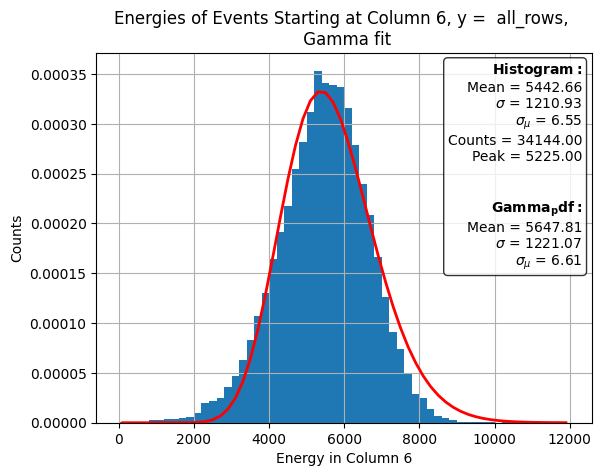

In [21]:
Gamma_fit_histo_single_column(hit_data_1093, 6, bin_size=200)

In [ ]:
def event_shower_energy_vs_X_position(hit_data, single_pad_only = "false", specific_Y = "false"):
    
    # get only showers starting at the first plane to identify the initial location
    plane_7 = hit_data[hit_data.plane == 7]
    if single_pad_only == "false":
        mask = ak.num(plane_7) > 0

    if single_pad_only == "true":
        mask = ak.num(plane_7) == 1

    first_plane_starting_events = hit_data[mask]

    # determine the initial location of the shower
    # get the data on the first plane
    plane_7_clean = plane_7[mask]
    plane_7_channel = plane_7_clean.ch
    
    # get the x and y positions of each channel
    y, x = divmod(plane_7_channel, 20) #y is the quontinent and is the row, x is the remainder and column
    
    # make x and y one dimensional
    x_list = x.to_list()
    x_ak = ak.Array(x_list)
    x_avg = ak.mean(x_ak, axis = 1)

        
    # compute the shower energy for each event
    hit_amp_array = first_plane_starting_events.amp
    event_shower_amp_array = ak.sum(hit_amp_array, axis = 1)

    # calculate for a specific row if needed
    if specific_Y  != "false":
        y = ak.flatten(y)
        mask_Y = y == specific_Y
        x_avg = x_avg[mask_Y]
        event_shower_amp_array = event_shower_amp_array[mask_Y]

    # get the average shower energy for each X position
    div, avg_amps, classes = rf.ak_groupby(x_avg, event_shower_amp_array)
    
    # get the energies in all column (2d array)
    energies_per_column = div.data
    
    # get the statistics for each column
    means = ak.mean(energies_per_column, axis=1)
    sigmas = ak.std(energies_per_column, axis=1)

    # mean unsertinty
    sem = sigmas / np.sqrt(ak.num(energies_per_column, axis=1))

    # plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # plot the energy avg per position vs the initial X position of the shower
    # ax1.plot(classes, avg_amps, marker='o')
    ax1.errorbar(
    classes, avg_amps, yerr=sem, fmt='-o',ecolor='black', elinewidth=1, capsize=4, capthick=1, markerfacecolor='blue', markersize=6, label='Data with error')

    ax1.set_xticks(np.arange(0, 20))
    ax1.grid(True, which='both', axis='x', linestyle='--', alpha=0.7)
    ax1.grid(True, which='both', axis='y', linestyle='--', alpha=0.7)
    ax1.set_xlabel('X Position at Shower Initiation [Pad Column]')
    ax1.set_ylabel('AVG Shower Energy')
    
    if specific_Y == "false":
        ax1.set_title('Average Shower Energy vs Initial Location')
    
    else:
        ax1.set_title(f'Average Shower Energy vs Initial Location, y = {specific_Y}')

    # show the amounnt of hits in each plane on a bar chart
    bins = np.arange(0, 21, 1) 
    ax2.hist(x_avg, bins=bins, edgecolor='black', rwidth=0.8)
    ax2.set_xticks(np.arange(0, 20) + 0.5)  # shift by 0.5
    ax2.set_xticklabels(np.arange(0, 20)) 
    ax2.grid(True, which='both', axis='x', linestyle='--', alpha=0.7)
    ax2.grid(True, which='both', axis='y', linestyle='--', alpha=0.7)
    ax2.set_xlabel('X Position [Pad Column]')
    ax2.set_ylabel('amount of hits')
    ax2.set_title('Amount of Events initiating in Each Column of the Sensor')
    
    plt.show()




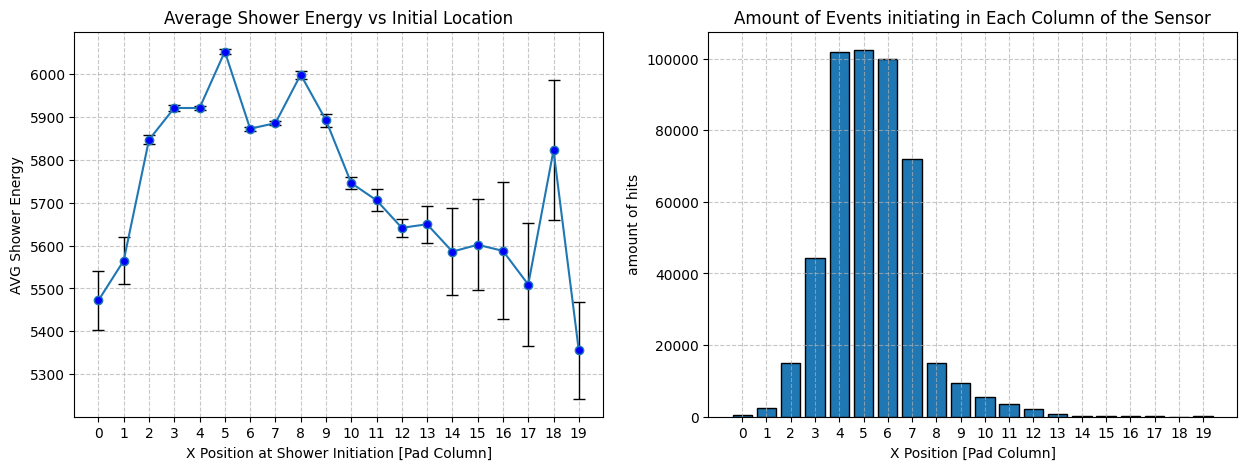

In [45]:
event_shower_energy_vs_X_position(hit_data_1093)